# Invest Soc QF Qn2

### Problem statement

Q2.  Develop a trading strategy/model using an asset (or a combination of assets) from G10 FX, Gold Continuous Futures, Govt Bonds ETF/Futures provided						

### Approach Overview
1. Data Preparation & Exploration
2. Feature Engineering
3. Model Development
4. Walk-Forward Validation
5. Performance Evaluation


In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import mplfinance as mpf
import backtrader as bt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

In [2]:
# data 
gold = pd.read_csv('data/Gold.csv', parse_dates=True, index_col=0, date_format='%m/%d/%y')
gold.head()

,Close,High,Low,Open,Volume
Date,,,,,
2014-01-02,15.179778,15.212941,14.848161,14.889613,17503697
2014-01-03,15.047136,15.353883,14.989104,15.279269,13976294
2014-01-06,15.212942,15.387040,15.063714,15.295847,11622763
2014-01-07,15.146621,15.171491,14.881327,15.080297,10216714
2014-01-08,14.889616,15.013974,14.740390,15.013974,13369077


In [3]:
gold.info()
gold.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2516 non-null   float64
 1   High    2516 non-null   float64
 2   Low     2516 non-null   float64
 3   Open    2516 non-null   float64
 4   Volume  2516 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


,Close,High,Low,Open,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,14.885227,15.110079,14.666015,14.896284,1.631677e+07
std,4.309338,4.359555,4.250347,4.317217,7.344741e+06
min,5.041925,5.288080,5.016461,5.160758,0.000000e+00
25%,11.606791,11.762850,11.421661,11.599643,1.113029e+07
50%,14.989721,15.205619,14.782459,15.011905,1.487344e+07
75%,17.324486,17.549096,17.043383,17.316417,1.984837e+07
max,27.110197,27.708836,26.674084,27.691087,6.722794e+07


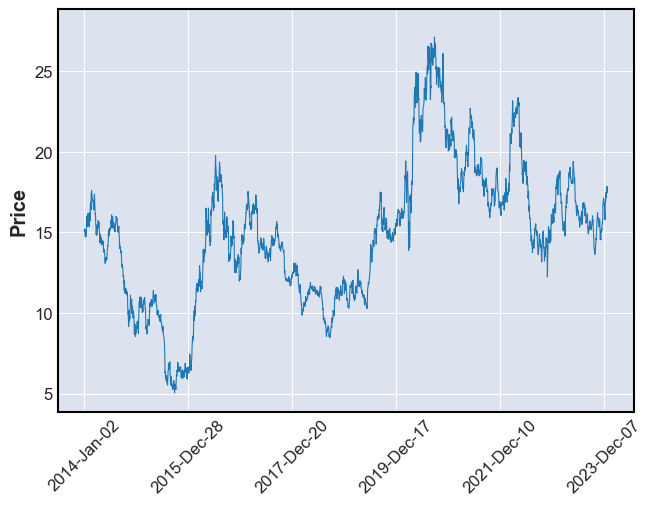

In [4]:
mpf.plot(gold, type='line')

In [5]:
gold['%Return'] = gold['Close'].pct_change()
gold['Return'] = gold['Close'].diff()
gold['Log_Return'] = np.log(gold['Close']).diff().dropna()
gold['Indicator'] = (gold['Return'].shift(-1) > 0).astype(bool)
gold

,Close,High,Low,Open,Volume,%Return,Return,Log_Return,Indicator
Date,,,,,,,,,
2014-01-02,15.179778,15.212941,14.848161,14.889613,17503697,NaN,NaN,NaN,False
2014-01-03,15.047136,15.353883,14.989104,15.279269,13976294,-0.008738,-0.132642,-0.008776,True
2014-01-06,15.212942,15.387040,15.063714,15.295847,11622763,0.011019,0.165806,0.010959,False
2014-01-07,15.146621,15.171491,14.881327,15.080297,10216714,-0.004360,-0.066321,-0.004369,False
2014-01-08,14.889616,15.013974,14.740390,15.013974,13369077,-0.016968,-0.257005,-0.017113,False
...,...,...,...,...,...,...,...,...,...
2023-12-22,17.547102,17.923939,17.547102,17.682376,21278581,0.010573,0.183588,0.010518,True
2023-12-26,17.556765,17.701123,17.460139,17.692039,6466234,0.000551,0.009663,0.000551,True
2023-12-27,17.846640,17.914279,17.614740,17.614740,12680993,0.016511,0.289875,0.016376,False


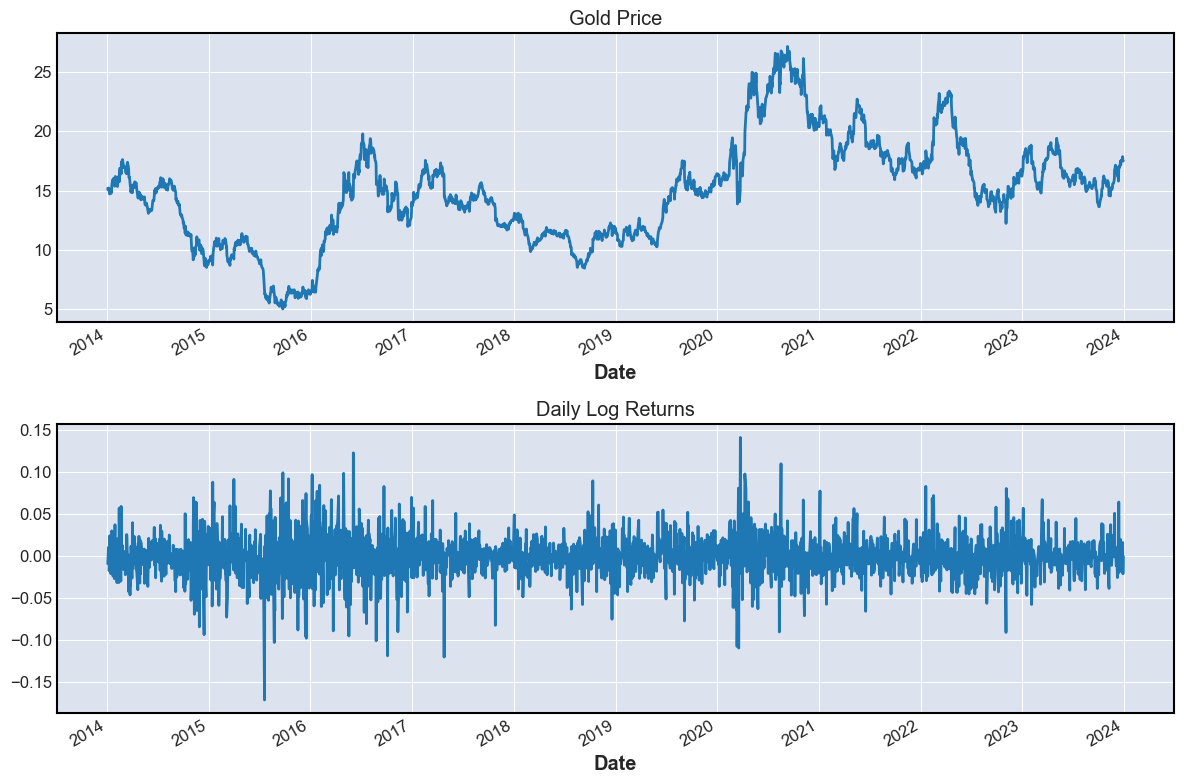

In [6]:
# Plot price and returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
gold['Close'].plot(ax=ax1, title='Gold Price')
gold['Log_Return'].plot(ax=ax2, title='Daily Log Returns')
plt.tight_layout()
plt.show()

In [7]:
# ARIMA modelling - confirming stationarity
adf_result = adfuller(gold['Log_Return'].dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

ADF Statistic: -50.4787
p-value: 0.0000


In [17]:
# ARIMA is not a good model
arima_model = ARIMA(gold['Log_Return'], order=(1,0,1))
arima_results = arima_model.fit()
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 2516
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5697.409
Date:                Sat, 14 Jun 2025   AIC                         -11386.818
Time:                        17:22:02   BIC                         -11363.496
Sample:                             0   HQIC                        -11378.354
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.112e-05      0.000      0.103      0.918      -0.001       0.001
ar.L1         -0.0036      2.285     -0.002      0.999      -4.482       4.475
ma.L1         -0.0036      2.283     -0.002      0.9

/Users/jaytai/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jaytai/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jaytai/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jaytai/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  war

Iteration:      5,   Func. Count:     34,   Neg. LLF: 5723.413630234103
Iteration:     10,   Func. Count:     63,   Neg. LLF: 5711.57219841125
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5711.572117553047
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5711.57
Distribution:                  Normal   AIC:                           11431.1
Method:            Maximum Likelihood   BIC:                           11454.5
                                        No. Observations:                 2515
Date:                Sat, Jun 14 2025   Df Residuals:                     2514
Time:           

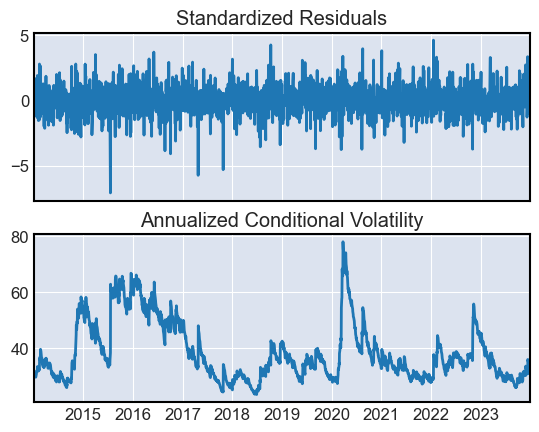

In [22]:
residuals = arima_results.resid
residuals = residuals.dropna()

# Fit GARCH(1,1) model
garch_model = arch_model(residuals*100, vol='GARCH', p=1, q=1)
garch_results = garch_model.fit(update_freq=5)
print(garch_results.summary())

# Plot standardized residuals and conditional volatility
garch_results.plot(annualize='D')
plt.show()

ValueError: x and y must be the same size

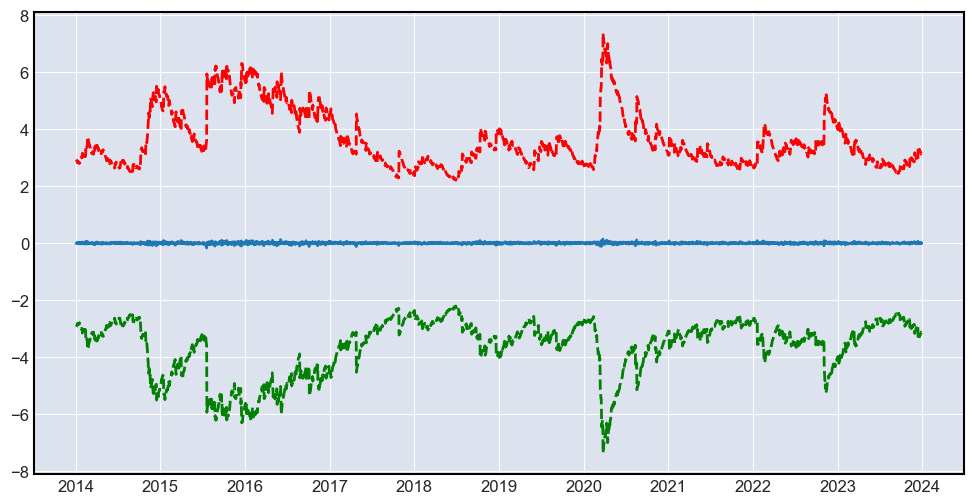

In [23]:
# Get conditional volatility
conditional_vol = garch_results.conditional_volatility

# Create Bollinger Bands
gold['ARIMA_Forecast'] = arima_results.predict()
gold['Upper_Band'] = gold['ARIMA_Forecast'] + 1.5*conditional_vol
gold['Lower_Band'] = gold['ARIMA_Forecast'] - 1.5*conditional_vol

# Generate signals
gold['Position'] = np.where(
    gold['Log_Return'] < gold['Lower_Band'], 
    1,  # Buy when price drops below lower band
    np.where(
        gold['Log_Return'] > gold['Upper_Band'],
        -1,  # Short when price exceeds upper band
        0     # Neutral otherwise
    )
)

# Plot signals
plt.figure(figsize=(12,6))
plt.plot(gold['Log_Return'], label='Returns')
plt.plot(gold['Upper_Band'], label='Upper Band', linestyle='--', color='red')
plt.plot(gold['Lower_Band'], label='Lower Band', linestyle='--', color='green')
plt.scatter(gold.index, gold['Log_Return'][gold['Position'] == 1], 
            color='green', label='Buy Signal', marker='^')
plt.scatter(gold.index, gold['Log_Return'][gold['Position'] == -1], 
            color='red', label='Sell Signal', marker='v')
plt.legend()
plt.title('ARIMA-GARCH Trading Signals')
plt.show()